In [1]:
import json
import os
import re
from io import StringIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from datetime import datetime

def load_json_files(directory):
    """Load all JSON files from a directory and return a dictionary with filenames as keys."""
    test_files = {}
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
                test_files[filename] = json.load(file)  # Store data with filename as key
    return test_files

def extract_tag_content(text, tag):
    """Extracts the substring between the last occurrence of <tag> and </tag> from the given text."""
    pattern = fr'<{tag}>(.*?)</{tag}>'
    matches = re.findall(pattern, text, re.DOTALL)
    return matches[-1].strip() if matches else None

def normalize_text(text):
    """Normalize text by removing punctuation and converting to lowercase."""
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', text).lower()

def find_patterns(text, patterns):
    """
    Find which patterns are in the text, ignoring case and punctuation.
    Returns a list of matched patterns.
    """
    normalized_text = normalize_text(text)
    matched_patterns = [pattern for pattern in patterns if normalize_text(pattern) in normalized_text]
    return matched_patterns

def find_error_rate(text, patterns):
    """Find error rates for given patterns in the text."""
    #normalized_text = normalize_text(text)
    results = {}
    for pattern in patterns:
        normalized_pattern = normalize_text(pattern)
        match = re.search(fr'{normalized_pattern}.*?error rate of (\d+)%', text)
        if match:
            results[pattern] = int(match.group(1))
    return results

def read_csv_from_text(text):
    data = StringIO(text)
    df = pd.read_csv(data)
    return df

def evaluate_diagnosis(true_diagnosis, predicted_diagnosis):
    """Evaluate how well the LLM identified imperfection patterns in text."""
    patterns = ["form-based event capture", "elusive case", "polluted label", "distorted label", "unanchored event"]

    # Find detected patterns in both true and predicted diagnoses
    true_detected = set(find_patterns(true_diagnosis, patterns))
    pred_detected = set(find_patterns(predicted_diagnosis, patterns))

    # Calculate precision, recall, and F1-score
    tp = len(true_detected & pred_detected)
    fp = len(pred_detected - true_detected)
    fn = len(true_detected - pred_detected)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {"precision": precision, "recall": recall, "f1": f1}, true_detected

def timestamp_deviation(df_erroneous, df_true, df_repaired):
    """Calculate the mean deviation of repaired timestamps from ground truth in seconds (only for erroneous events)."""
    merged_err = df_erroneous.merge(df_true, on="event_id", suffixes=("_err", "_true"))
    erroneous_events = merged_err[merged_err["timestamp_err"] != merged_err["timestamp_true"]]["event_id"]
    df_true_filtered = df_true[df_true["event_id"].isin(erroneous_events)]
    df_repaired_filtered = df_repaired[df_repaired["event_id"].isin(erroneous_events)]
    merged = df_true_filtered.merge(df_repaired_filtered, on="event_id", suffixes=("_true", "_repaired"))
    merged["timestamp_true"] = pd.to_datetime(merged["timestamp_true"], errors='coerce')
    merged["timestamp_repaired"] = pd.to_datetime(merged["timestamp_repaired"], errors='coerce')
    merged["deviation"] = (merged["timestamp_repaired"] - merged["timestamp_true"]).dt.total_seconds().abs()
    return merged["deviation"].mean()

def timestamp_accuracy(df_erroneous, df_true, df_repaired):
    """Calculate the accuracy of perfectly corrected timestamps using string comparison (only for erroneous events)."""
    merged_err = df_erroneous.merge(df_true, on="event_id", suffixes=("_err", "_true"))
    erroneous_events = merged_err[merged_err["timestamp_err"] != merged_err["timestamp_true"]]["event_id"]
    df_true_filtered = df_true[df_true["event_id"].isin(erroneous_events)]
    df_repaired_filtered = df_repaired[df_repaired["event_id"].isin(erroneous_events)]
    merged = df_true_filtered.merge(df_repaired_filtered, on="event_id", suffixes=("_true", "_repaired"))
    correct_timestamps = (merged["timestamp_true"].astype(str) == merged["timestamp_repaired"].astype(str)).sum()
    total_timestamps = len(merged)
    return correct_timestamps / total_timestamps if total_timestamps > 0 else 0

def case_id_accuracy(df_erroneous, df_true, df_repaired):
    """Calculate the accuracy of restored case IDs (only for erroneous events)."""
    merged_err = df_erroneous.merge(df_true, on="event_id", suffixes=("_err", "_true"))
    erroneous_events = merged_err[merged_err["case_id_err"] != merged_err["case_id_true"]]["event_id"]
    df_true_filtered = df_true[df_true["event_id"].isin(erroneous_events)]
    df_repaired_filtered = df_repaired[df_repaired["event_id"].isin(erroneous_events)]
    merged = df_true_filtered.merge(df_repaired_filtered, on="event_id", suffixes=("_true", "_repaired"))
    correct_cases = (merged["case_id_true"] == merged["case_id_repaired"]).sum()
    total_cases = len(merged)
    return correct_cases / total_cases if total_cases > 0 else 0

def label_accuracy(df_erroneous, df_true, df_repaired):
    """Calculate the accuracy of restored activity labels (only for erroneous events)."""
    merged_err = df_erroneous.merge(df_true, on="event_id", suffixes=("_err", "_true"))
    erroneous_events = merged_err[merged_err["activity_err"] != merged_err["activity_true"]]["event_id"]
    df_true_filtered = df_true[df_true["event_id"].isin(erroneous_events)]
    df_repaired_filtered = df_repaired[df_repaired["event_id"].isin(erroneous_events)]
    merged = df_true_filtered.merge(df_repaired_filtered, on="event_id", suffixes=("_true", "_repaired"))
    correct_labels = (merged["activity_true"] == merged["activity_repaired"]).sum()
    total_labels = len(merged)
    return correct_labels / total_labels if total_labels > 0 else 0

def evaluate_log_repairs(df_erroneous, df_true, df_repaired, true_patterns):
    """Evaluate how well the log was repaired based on detected patterns."""
    metrics = {}
    if "form-based event capture" in true_patterns:
        metrics["timestamp_deviation"] = timestamp_deviation(df_erroneous, df_true, df_repaired)
    if "unanchored event" in true_patterns:
        metrics["timestamp_accuracy"] = timestamp_accuracy(df_erroneous, df_true, df_repaired)
    if "elusive case" in true_patterns:
        metrics["case_id_accuracy"] = case_id_accuracy(df_erroneous, df_true, df_repaired)
    if "polluted label" in true_patterns:
        metrics["polluted_label_accuracy"] = label_accuracy(df_erroneous, df_true, df_repaired)
    if "distorted label" in true_patterns:
        metrics["distorted_label_accuracy"] = label_accuracy(df_erroneous, df_true, df_repaired)
    return metrics

def get_failure_template(ground_truth_diagnosis):
    patterns = ["form-based event capture", "elusive case", "polluted label", "distorted label", "unanchored event"]
    injected = set(find_patterns(ground_truth_diagnosis, patterns))
    repair_metrics = {}
    if "form-based event capture" in injected:
        repair_metrics["timestamp_deviation"] = 0.0
    if "unanchored event" in injected:
        repair_metrics["timestamp_accuracy"] = 0.0
    if "elusive case" in injected:
        repair_metrics["case_id_accuracy"] = 0.0
    if "polluted label" in injected:
        repair_metrics["polluted_label_accuracy"] = 0.0
    if "distorted label" in injected:
        repair_metrics["distorted_label_accuracy"] = 0.0
    
    failure_template = {
        "diagnosis": {"precision": 0.0, "recall": 0.0, "f1": 0.0},
        "patterns_injected": list(injected),
        "repair": repair_metrics
    }
    
    return failure_template
      

def evaluate_model(test_files, skip_errors=True):
    """Run evaluation on all test files (provided as a dict keyed by filename) and return a dict with filenames as keys."""
    results = {}
    for filename, test_file in test_files.items():
        # Extract ground truth data
        erroneous_log = test_file["input"]
        df_erroneous = read_csv_from_text(erroneous_log)
        ground_truth_log = extract_tag_content(test_file["output"], "log")
        df_true = read_csv_from_text(ground_truth_log)
        ground_truth_diagnosis = extract_tag_content(test_file["output"], "diagnosis")
        
        # metrics for failures template
        if not skip_errors:
            failure_template = get_failure_template(ground_truth_diagnosis)
        
            
        # Extract generated data
        try:
            predicted_output = test_file["predicted_output"]
            generated_log = extract_tag_content(predicted_output, "log")
            if generated_log is None:
                generated_log = extract_tag_content(predicted_output + '</log>', "log")
            if generated_log is None:
                #print(f"{filename}: empty log")
                if not skip_errors:
                    failure_template = get_failure_template(ground_truth_diagnosis)
                    results[filename] = failure_template
                continue
            df_repaired = read_csv_from_text(generated_log)
            if list(df_repaired.columns) != ['event_id', 'case_id', 'activity', 'timestamp']:
                #print(f"{filename}: defective log with columns", df_repaired.columns)
                if not skip_errors:
                    failure_template = get_failure_template(ground_truth_diagnosis)
                    results[filename] = failure_template
                continue
            generated_diagnosis = extract_tag_content(predicted_output, "diagnosis")
            if generated_diagnosis is None:
                #print(f"{filename}: empty diagnosis")
                if not skip_errors:
                    failure_template = get_failure_template(ground_truth_diagnosis)
                    results[filename] = failure_template
                continue
        except Exception as e:
            #print(f"{filename}: {e}")
            if not skip_errors:
                failure_template = get_failure_template(ground_truth_diagnosis)
                results[filename] = failure_template
            continue

        # Evaluate diagnosis and repairs
        diagnosis_metrics, patterns_injected = evaluate_diagnosis(ground_truth_diagnosis, generated_diagnosis)
        repair_metrics = evaluate_log_repairs(df_erroneous, df_true, df_repaired, patterns_injected)

        # Store results for this file
        results[filename] = {
            "diagnosis": diagnosis_metrics,
            "patterns_injected": list(patterns_injected),
            "repair": repair_metrics
        }
        #print(f"{filename}: success")
    return results

def initialize_results(train_dir='../data/train'):
    """
    Initializes the results dictionary based on the CSV files in the given train directory.
    
    Parameters:
        train_dir (str): Path to the training data directory.
    
    Returns:
        dict: A dictionary with keys from the CSV filenames (without .csv extension) 
              and initialized structures for diagnosis and repair metrics.
    """
    results = {}
    for base_file in os.listdir(train_dir):
        full_path = os.path.join(train_dir, base_file)
        # Only process if it's a file and ends with .csv
        if os.path.isfile(full_path) and base_file.endswith('.csv'):
            base_log_name = base_file.split('.csv')[0]
            results[base_log_name] = {
                'diagnosis': {"precision": [], "recall": [], "f1": []},
                'repair': {
                    'timestamp_deviation': {x: [] for x in range(10, 110, 10)},
                    'timestamp_accuracy': {x: [] for x in range(10, 110, 10)},
                    'case_id_accuracy': {x: [] for x in range(10, 110, 10)},
                    'polluted_label_accuracy': {x: [] for x in range(10, 110, 10)},
                    'distorted_label_accuracy': {x: [] for x in range(10, 110, 10)},
                }
            }
    return results

def process_evaluation_item(log_name, item, results, test_files):
    """
    Processes a single evaluation result item and aggregates its metrics into the results dictionary.
    
    Parameters:
        log_name (str): The name of the log file.
        item (dict): The evaluation result for the log.
        results (dict): The aggregated results dictionary.
        test_files (dict): Dictionary containing test file outputs.
    """
    base_log_name = log_name.split('.csv')[0]
    
    # Add diagnosis metrics
    diagnosis_metrics = item['diagnosis']
    results[base_log_name]['diagnosis']['precision'].append(diagnosis_metrics['precision'])
    results[base_log_name]['diagnosis']['recall'].append(diagnosis_metrics['recall'])
    results[base_log_name]['diagnosis']['f1'].append(diagnosis_metrics['f1'])
    
    # Extract error rates for repair metrics
    patterns_injected = item['patterns_injected']
    true_output = test_files[log_name]['output']
    true_diagnosis = extract_tag_content(true_output, 'diagnosis')
    error_to_rate = find_error_rate(true_diagnosis, patterns_injected)
    
    # Add repair metrics based on injected patterns and computed error rates
    if "form-based event capture" in patterns_injected:
        results[base_log_name]['repair']['timestamp_deviation'][error_to_rate['form-based event capture']].append(
            item['repair']['timestamp_deviation']
        )
    if "unanchored event" in patterns_injected:
        results[base_log_name]['repair']['timestamp_accuracy'][error_to_rate['unanchored event']].append(
            item['repair']['timestamp_accuracy']
        )
    if "elusive case" in patterns_injected:
        results[base_log_name]['repair']['case_id_accuracy'][error_to_rate['elusive case']].append(
            item['repair']['case_id_accuracy']
        )
    if "polluted label" in patterns_injected:
        results[base_log_name]['repair']['polluted_label_accuracy'][error_to_rate['polluted label']].append(
            item['repair']['polluted_label_accuracy']
        )
    if "distorted label" in patterns_injected:
        results[base_log_name]['repair']['distorted_label_accuracy'][error_to_rate['distorted label']].append(
            item['repair']['distorted_label_accuracy']
        )

def aggregate_evaluation_results(evaluation_results, test_files, results):
    """
    Iterates over evaluation results and aggregates each item into the results dictionary.
    
    Parameters:
        evaluation_results (dict): A dictionary with evaluation metrics for each log.
        test_files (dict): Dictionary containing test file outputs.
        results (dict): The aggregated results dictionary to update.
    """
    for log_name, item in evaluation_results.items():
        process_evaluation_item(log_name, item, results, test_files)

def aggregate_results(train_dir, evaluation_results, test_files):
    """
    Main function to initialize results and aggregate evaluation metrics.
    
    Parameters:
        train_dir (str): The directory containing training data CSV files.
        evaluation_results (dict): The evaluation results for each log.
        test_files (dict): Dictionary containing test file outputs.
    
    Returns:
        dict: The aggregated results dictionary.
    """
    results = initialize_results(train_dir)
    aggregate_evaluation_results(evaluation_results, test_files, results)
    return results

def compute_median(values):
    # If values is not iterable, wrap it in a list.
    if not isinstance(values, (list, tuple, np.ndarray)):
        values = [values]
    if len(values) == 0:
        return np.nan
    return np.median(values)

def compute_mean(values):
    # If values is not iterable, wrap it in a list.
    if not isinstance(values, (list, tuple, np.ndarray)):
        values = [values]
    if len(values) == 0:
        return np.nan
    return np.mean(values)

def get_diagnosis_results(results):
    diagnosis_rows = []
    for log_name, log_data in results.items():
        diag = log_data.get('diagnosis', {})
        #precision = compute_median(diag.get('precision', []))
        #recall    = compute_median(diag.get('recall', []))
        #f1        = compute_median(diag.get('f1', []))
        precision = compute_mean(diag.get('precision', []))
        recall    = compute_mean(diag.get('recall', []))
        f1        = compute_mean(diag.get('f1', []))
        diagnosis_rows.append({
            'log': log_name,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    df_diagnosis = pd.DataFrame(diagnosis_rows)
    return df_diagnosis

def get_repair_results(results):
    repair_rows = []
    repair_metric_names = [
        'timestamp_deviation', 'timestamp_accuracy', 'case_id_accuracy', 
        'polluted_label_accuracy', 'distorted_label_accuracy', 
    ]

    for log_name, log_data in results.items():
        repair = log_data.get('repair', {})
        # Get all unique error rates across the repair metrics
        error_rates = set()
        for metric in repair_metric_names:
            error_rates.update(repair.get(metric, {}).keys())
        # For each error rate (sorted numerically) compute the mean for each metric
        for error_rate in sorted(error_rates, key=lambda x: int(x)):
            row = {'log': log_name, 'error_rate': error_rate}
            for metric in repair_metric_names:
                values = repair.get(metric, {}).get(error_rate, [])
                #row[metric] = compute_median(values)
                row[metric] = compute_mean(values)
            repair_rows.append(row)

    df_repair = pd.DataFrame(repair_rows)
    return df_repair

In [2]:
directory = "../data/instruction/eval_predictions/individual/"
test_files = load_json_files(directory)
evaluation_results = evaluate_model(test_files, skip_errors=True)
aggregated_results = aggregate_results('../data/train', evaluation_results, test_files)
df_diagnosis = get_diagnosis_results(aggregated_results)
df_repair = get_repair_results(aggregated_results)

In [6]:
def demonstrate_result(file):
    generated_output = test_files[file]['predicted_output']
    ground_truth = test_files[file]['output']
    
    for tag in ['diagnosis', 'mitigation', 'log']:
        generated_content = extract_tag_content(generated_output, tag)
        ground_truth_content = extract_tag_content(ground_truth, tag)
        
        print("*"*10, f"Now comparing {tag}", "*"*10)
        print("\nGround truth:\n", ground_truth_content)
        print("\nGenerated content:\n", generated_content)
        print("\n\n")
        
current_sample = '2020_DomesticDeclarations.csv_batch_12_combination_32.json'
demonstrate_result(current_sample)

********** Now comparing diagnosis **********

Ground truth:
 Detected unanchored event: 89 affected events which corresponds to an error rate of 60%. This pattern was detected due to inconsistencies in timestamp formatting, such as variations in date-month or month-date format. Detected elusive case: 119 affected events which corresponds to an error rate of 80%. This pattern was detected because some events are missing case IDs. Detected distorted label: 74 affected events which corresponds to an error rate of 50%. This pattern was detected because activity labels contain minor spelling errors or variations.

Generated content:
 Detected unanchored event: 90 affected events which corresponds to an error rate of 60%. This pattern was detected due to inconsistencies in timestamp formatting, such as variations in date-month or month-date format. Detected elusive case: 120 affected events which corresponds to an error rate of 80%. This pattern was detected because some events are missing 

In [7]:
df_diagnosis.sort_values(by='log')

log  precision    recall        f1
1              2012_BPI_Challenge   0.942943  0.928679  0.933634
2              2018_BPI_Challenge   0.969697  0.968687  0.969091
4              2019_BPI_Challenge   0.993377  0.986203  0.988190
6       2020_DomesticDeclarations   0.976190  0.973287  0.974332
5  2020_InternationalDeclarations   0.985185  0.983333  0.983951
3                  2020_PermitLog   0.963576  0.974062  0.964680
7          2020_PrepaidTravelCost   0.978610  0.977718  0.977184
0          2020_RequestForPayment   0.987179  0.982479  0.983590

In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_repair)

log  error_rate  timestamp_deviation  \
0           2020_RequestForPayment          10         2.875601e+05   
1           2020_RequestForPayment          20         3.358963e+05   
2           2020_RequestForPayment          30         5.498337e+05   
3           2020_RequestForPayment          40         8.062261e+05   
4           2020_RequestForPayment          50                  NaN   
5           2020_RequestForPayment          60         2.870912e+05   
6           2020_RequestForPayment          70         5.226575e+05   
7           2020_RequestForPayment          80         6.646133e+05   
8           2020_RequestForPayment          90         4.840499e+05   
9           2020_RequestForPayment         100         4.144631e+05   
10              2012_BPI_Challenge          10         4.243778e+05   
11              2012_BPI_Challenge          20         2.941289e+05   
12              2012_BPI_Challenge          30         2.004384e+05   
13              2012_BPI_Challenge          40         3.451484e+05   
14              2012_BPI_Challenge          50         4.242638e+05   
15              2012_BPI_Challenge          60         3.831272e+05   
16              2012_BPI_Challenge          70                  NaN   
17              2012_BPI_Challenge          80         3.290122e+05   
18              2012_BPI_Challenge          90         2.769729e+05   
19              2012_BPI_Challenge         100         3.648598e+05   
20              2018_BPI_Challenge          10         7.698640e+06   
21              2018_BPI_Challenge          20         2.809533e+06   
22              2018_BPI_Challenge          30         3.205276e+06   
23              2018_BPI_Challenge          40         4.439849e+06   
24              2018_BPI_Challenge          50         4.101427e+06   
25              2018_BPI_Challenge          60         5.608869e+06   
26              2018_BPI_Challenge          70         3.338521e+06   
27              2018_BPI_Challenge          80         2.897175e+06   
28              2018_BPI_Challenge          90         4.272056e+06   
29              2018_BPI_Challenge         100         3.619329e+06   
30                  2020_PermitLog          10         7.858236e+05   
31                  2020_PermitLog          20         1.051110e+06   
32                  2020_PermitLog          30         1.622023e+06   
33                  2020_PermitLog          40         1.202679e+06   
34                  2020_PermitLog          50                  NaN   
35                  2020_PermitLog          60         1.414290e+06   
36                  2020_PermitLog          70         1.515171e+06   
37                  2020_PermitLog          80                  NaN   
38                  2020_PermitLog          90         1.653375e+06   
39                  2020_PermitLog         100         1.361963e+06   
40              2019_BPI_Challenge          10         6.868230e+05   
41              2019_BPI_Challenge          20         1.021382e+06   
42              2019_BPI_Challenge          30         9.300488e+05   
43              2019_BPI_Challenge          40         7.015193e+05   
44              2019_BPI_Challenge          50         8.938824e+05   
45              2019_BPI_Challenge          60         1.012776e+06   
46              2019_BPI_Challenge          70         1.493724e+06   
47              2019_BPI_Challenge          80         1.306076e+06   
48              2019_BPI_Challenge          90         2.110624e+06   
49              2019_BPI_Challenge         100         1.407627e+06   
50  2020_InternationalDeclarations          10         1.880948e+05   
51  2020_InternationalDeclarations          20         6.446214e+05   
52  2020_InternationalDeclarations          30         4.536673e+05   
53  2020_InternationalDeclarations          40         5.123585e+05   
54  2020_InternationalDeclarations          50         6.606522e+05   
55  2020_InternationalDeclarations          60         

# No Repair Baseline

In [10]:
import json
import os
import re
from io import StringIO
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime

def load_json_files(directory):
    """Load all JSON files from a directory and return a dictionary with filenames as keys."""
    test_files = {}
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
                test_files[filename] = json.load(file)  # Store data with filename as key
    return test_files

def extract_tag_content(text, tag):
    """Extracts the substring between the last occurrence of <tag> and </tag> from the given text."""
    pattern = fr'<{tag}>(.*?)</{tag}>'
    matches = re.findall(pattern, text, re.DOTALL)
    return matches[-1].strip() if matches else None

def normalize_text(text):
    """Normalize text by removing punctuation and converting to lowercase."""
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', text).lower()

def find_patterns(text, patterns):
    """
    Find which patterns are in the text, ignoring case and punctuation.
    Returns a list of matched patterns.
    """
    normalized_text = normalize_text(text)
    matched_patterns = [pattern for pattern in patterns if normalize_text(pattern) in normalized_text]
    return matched_patterns

def find_error_rate(text, patterns):
    """Find error rates for given patterns in the text."""
    #normalized_text = normalize_text(text)
    results = {}
    for pattern in patterns:
        normalized_pattern = normalize_text(pattern)
        match = re.search(fr'{normalized_pattern}.*?error rate of (\d+)%', text)
        if match:
            results[pattern] = int(match.group(1))
    return results

def read_csv_from_text(text):
    data = StringIO(text)
    df = pd.read_csv(data)
    return df

def timestamp_deviation(df_erroneous, df_true, df_repaired):
    """Calculate the mean deviation of repaired timestamps from ground truth in seconds (only for erroneous events)."""
    merged_err = df_erroneous.merge(df_true, on="event_id", suffixes=("_err", "_true"))
    erroneous_events = merged_err[merged_err["timestamp_err"] != merged_err["timestamp_true"]]["event_id"]
    df_true_filtered = df_true[df_true["event_id"].isin(erroneous_events)]
    df_repaired_filtered = df_repaired[df_repaired["event_id"].isin(erroneous_events)]
    merged = df_true_filtered.merge(df_repaired_filtered, on="event_id", suffixes=("_true", "_repaired"))
    merged["timestamp_true"] = pd.to_datetime(merged["timestamp_true"], errors='coerce')
    merged["timestamp_repaired"] = pd.to_datetime(merged["timestamp_repaired"], errors='coerce')
    merged["deviation"] = (merged["timestamp_repaired"] - merged["timestamp_true"]).dt.total_seconds().abs()
    return merged["deviation"].mean()

def evaluate_log_repairs(df_erroneous, df_true, df_repaired, true_patterns):
    """Evaluate how well the log was repaired based on detected patterns."""
    metrics = {}
    if "form-based event capture" in true_patterns:
        metrics["timestamp_deviation"] = timestamp_deviation(df_erroneous, df_true, df_repaired)
    return metrics

def evaluate_model(test_files, skip_errors=True):
    """Run evaluation on all test files (provided as a dict keyed by filename) and return a dict with filenames as keys."""
    results = {}
    for filename, test_file in test_files.items():
        # Extract ground truth data
        erroneous_log = test_file["input"]
        df_erroneous = read_csv_from_text(erroneous_log)
        ground_truth_log = extract_tag_content(test_file["output"], "log")
        df_true = read_csv_from_text(ground_truth_log)
        ground_truth_diagnosis = extract_tag_content(test_file["output"], "diagnosis")
        
        patterns = ["form-based event capture", "elusive case", "polluted label", "distorted label", "unanchored event"]
        patterns_injected = set(find_patterns(ground_truth_diagnosis, patterns))
        
        # Extract generated data
        try:
            predicted_output = test_file["predicted_output"]
            generated_log = extract_tag_content(predicted_output, "log")
            df_repaired = read_csv_from_text(generated_log)

        except Exception as e:
            #print(f"{filename}: {e}")
            if not skip_errors:
                failure_template = get_failure_template(ground_truth_diagnosis)
                results[filename] = failure_template
            continue

        # Evaluate repair
        repair_metrics = evaluate_log_repairs(df_erroneous, df_true, df_repaired, patterns_injected)

        # Store results for this file
        results[filename] = {
            "patterns_injected": list(patterns_injected),
            "repair": repair_metrics
        }
        #print(f"{filename}: success")
    return results

def initialize_results(train_dir='../data/train'):
    """
    Initializes the results dictionary based on the CSV files in the given train directory.
    
    Parameters:
        train_dir (str): Path to the training data directory.
    
    Returns:
        dict: A dictionary with keys from the CSV filenames (without .csv extension) 
              and initialized structures for diagnosis and repair metrics.
    """
    results = {}
    for base_file in os.listdir(train_dir):
        full_path = os.path.join(train_dir, base_file)
        # Only process if it's a file and ends with .csv
        if os.path.isfile(full_path) and base_file.endswith('.csv'):
            base_log_name = base_file.split('.csv')[0]
            results[base_log_name] = {
                'repair': {
                    'timestamp_deviation': {x: [] for x in range(10, 110, 10)},
                    'timestamp_accuracy': {x: [] for x in range(10, 110, 10)},
                    'case_id_accuracy': {x: [] for x in range(10, 110, 10)},
                    'polluted_label_accuracy': {x: [] for x in range(10, 110, 10)},
                    'distorted_label_accuracy': {x: [] for x in range(10, 110, 10)},
                }
            }
    return results

def process_evaluation_item(log_name, item, results, test_files):
    """
    Processes a single evaluation result item and aggregates its metrics into the results dictionary.
    
    Parameters:
        log_name (str): The name of the log file.
        item (dict): The evaluation result for the log.
        results (dict): The aggregated results dictionary.
        test_files (dict): Dictionary containing test file outputs.
    """
    base_log_name = log_name.split('.csv')[0]
    
    
    # Extract error rates for repair metrics
    patterns_injected = item['patterns_injected']
    true_output = test_files[log_name]['output']
    true_diagnosis = extract_tag_content(true_output, 'diagnosis')
    error_to_rate = find_error_rate(true_diagnosis, patterns_injected)
    
    # Add repair metrics based on injected patterns and computed error rates
    if "form-based event capture" in patterns_injected:
        results[base_log_name]['repair']['timestamp_deviation'][error_to_rate['form-based event capture']].append(
            item['repair']['timestamp_deviation']
        )

def aggregate_evaluation_results(evaluation_results, test_files, results):
    """
    Iterates over evaluation results and aggregates each item into the results dictionary.
    
    Parameters:
        evaluation_results (dict): A dictionary with evaluation metrics for each log.
        test_files (dict): Dictionary containing test file outputs.
        results (dict): The aggregated results dictionary to update.
    """
    for log_name, item in evaluation_results.items():
        process_evaluation_item(log_name, item, results, test_files)

def aggregate_results(train_dir, evaluation_results, test_files):
    """
    Main function to initialize results and aggregate evaluation metrics.
    
    Parameters:
        train_dir (str): The directory containing training data CSV files.
        evaluation_results (dict): The evaluation results for each log.
        test_files (dict): Dictionary containing test file outputs.
    
    Returns:
        dict: The aggregated results dictionary.
    """
    results = initialize_results(train_dir)
    aggregate_evaluation_results(evaluation_results, test_files, results)
    return results

def compute_median(values):
    # If values is not iterable, wrap it in a list.
    if not isinstance(values, (list, tuple, np.ndarray)):
        values = [values]
    if len(values) == 0:
        return np.nan
    return np.median(values)

def compute_mean(values):
    # If values is not iterable, wrap it in a list.
    if not isinstance(values, (list, tuple, np.ndarray)):
        values = [values]
    if len(values) == 0:
        return np.nan
    return np.mean(values)

def get_repair_results(results):
    repair_rows = []
    repair_metric_names = [
        'timestamp_deviation', 'timestamp_accuracy', 'case_id_accuracy', 
        'polluted_label_accuracy', 'distorted_label_accuracy', 
    ]

    for log_name, log_data in results.items():
        repair = log_data.get('repair', {})
        # Get all unique error rates across the repair metrics
        error_rates = set()
        for metric in repair_metric_names:
            error_rates.update(repair.get(metric, {}).keys())
        # For each error rate (sorted numerically) compute the mean for each metric
        for error_rate in sorted(error_rates, key=lambda x: int(x)):
            row = {'log': log_name, 'error_rate': error_rate}
            for metric in repair_metric_names:
                values = repair.get(metric, {}).get(error_rate, [])
                #row[metric] = compute_median(values)
                row[metric] = compute_mean(values)
            repair_rows.append(row)

    df_repair = pd.DataFrame(repair_rows)
    return df_repair

In [11]:
directory = "../data/instruction/eval_predictions/individual/"
test_files = load_json_files(directory)

# for no repair overwrite generated output with input
for key in test_files.keys():
    test_files[key]['predicted_output'] = '<log>' + test_files[key]['input'] + '</log>'

In [12]:
evaluation_results = evaluate_model(test_files, skip_errors=False)
aggregated_results = aggregate_results('../data/train', evaluation_results, test_files)
df_repair_no_repair = get_repair_results(aggregated_results)

/tmp/ipykernel_786994/3735065299.py:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged["timestamp_true"] = pd.to_datetime(merged["timestamp_true"], errors='coerce')


# Visualization - Accuracy Metrics

In [13]:
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase or decrease font size

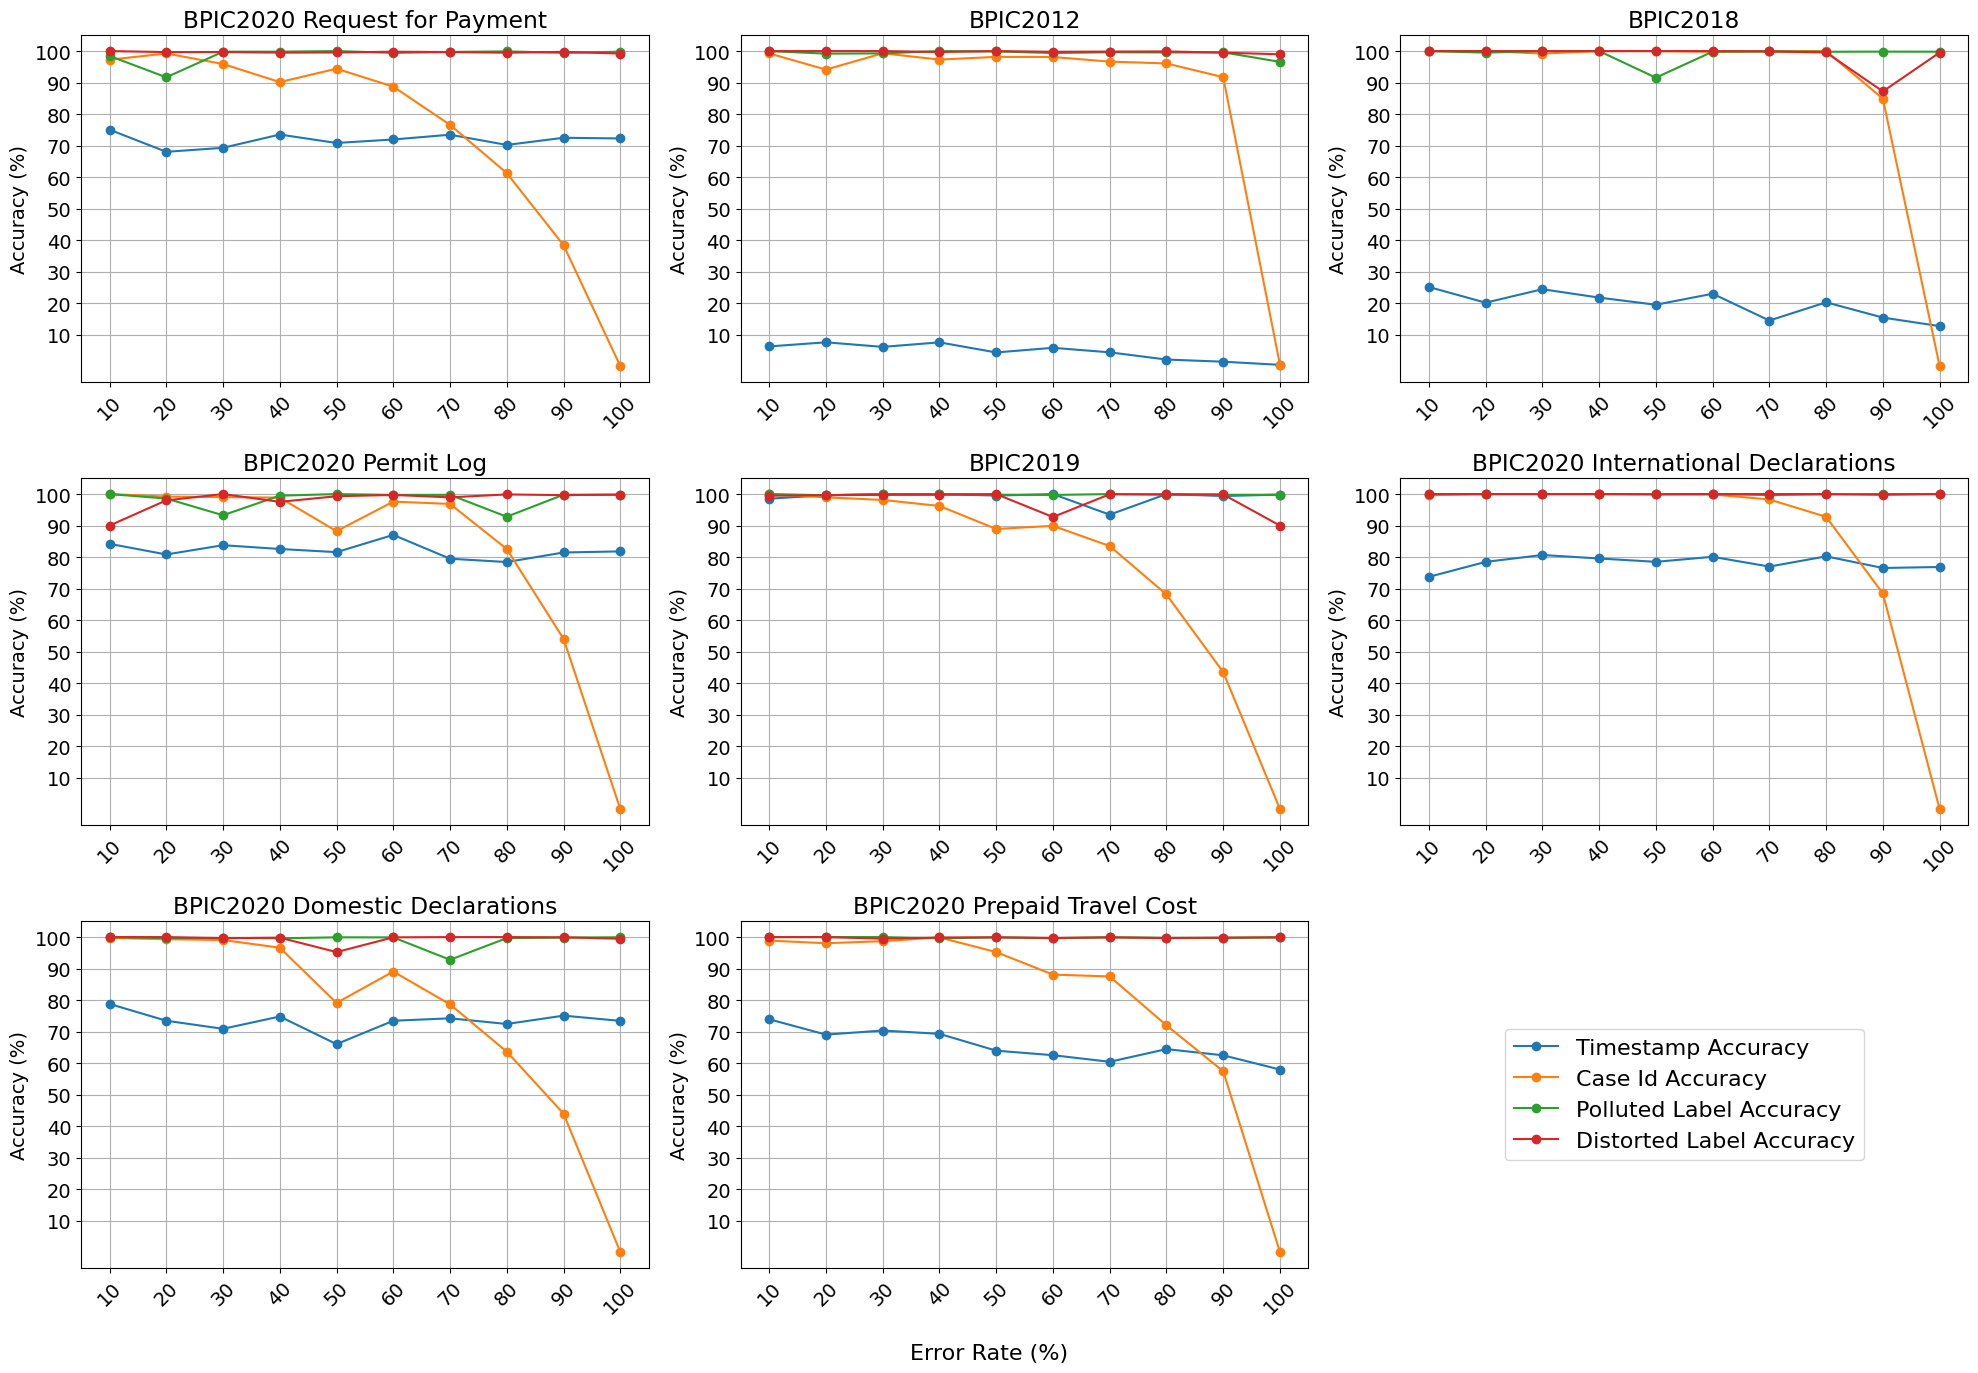

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

log_names = {
    '2020_RequestForPayment' : 'BPIC2020 Request for Payment',
    '2020_PermitLog' : 'BPIC2020 Permit Log',
    '2020_DomesticDeclarations' : 'BPIC2020 Domestic Declarations',
    '2020_InternationalDeclarations' : 'BPIC2020 International Declarations',
    '2020_PrepaidTravelCost' : 'BPIC2020 Prepaid Travel Cost',
    '2012_BPI_Challenge' : 'BPIC2012',
    '2018_BPI_Challenge' : 'BPIC2018',
    '2019_BPI_Challenge' : 'BPIC2019',
}

accuracy_metrics = ['timestamp_accuracy', 'case_id_accuracy', 'polluted_label_accuracy', 'distorted_label_accuracy']
logs = df_repair['log'].unique()
num_logs = len(logs)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axs = axs.flatten()

# Collect handles and labels for the legend
handles, labels = [], []
collected_metrics = set()

for ax, log in zip(axs, logs):
    df_log = df_repair[df_repair['log'] == log]
    for metric in accuracy_metrics:
        line, = ax.plot(df_log['error_rate'], df_log[metric]*100, marker='o', label=metric)
        if metric not in collected_metrics:
            handles.append(line)
            labels.append(metric.replace('_', ' ').title())
            collected_metrics.add(metric)
    
    ax.set_title(f'{log_names[log]}')
    ax.set_ylabel('Accuracy (%)')
    ax.set_xticks(df_log['error_rate'].unique())
    ax.set_yticks(df_log['error_rate'].unique())
    ax.tick_params(axis='x', labelrotation=45, labelbottom=True)
    ax.set_xlim(5, 105)
    ax.set_ylim(-5, 105)
    ax.grid(True)

# Remove content from the last unused subplot and place the legend there
empty_ax = axs[-1]
empty_ax.axis('off')
empty_ax.legend(handles, labels, loc='center', fontsize=16)

#fig.suptitle('Accuracy Metrics Across Test Logs', fontsize=16)
fig.text(0.5, 0.04, 'Error Rate (%)', ha='center', va='center', fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('../models/OTRTA_v7_instruct_base_new_system/accuracy_metrics.png', bbox_inches='tight')
plt.show()


# Timestamp Deviation Plots

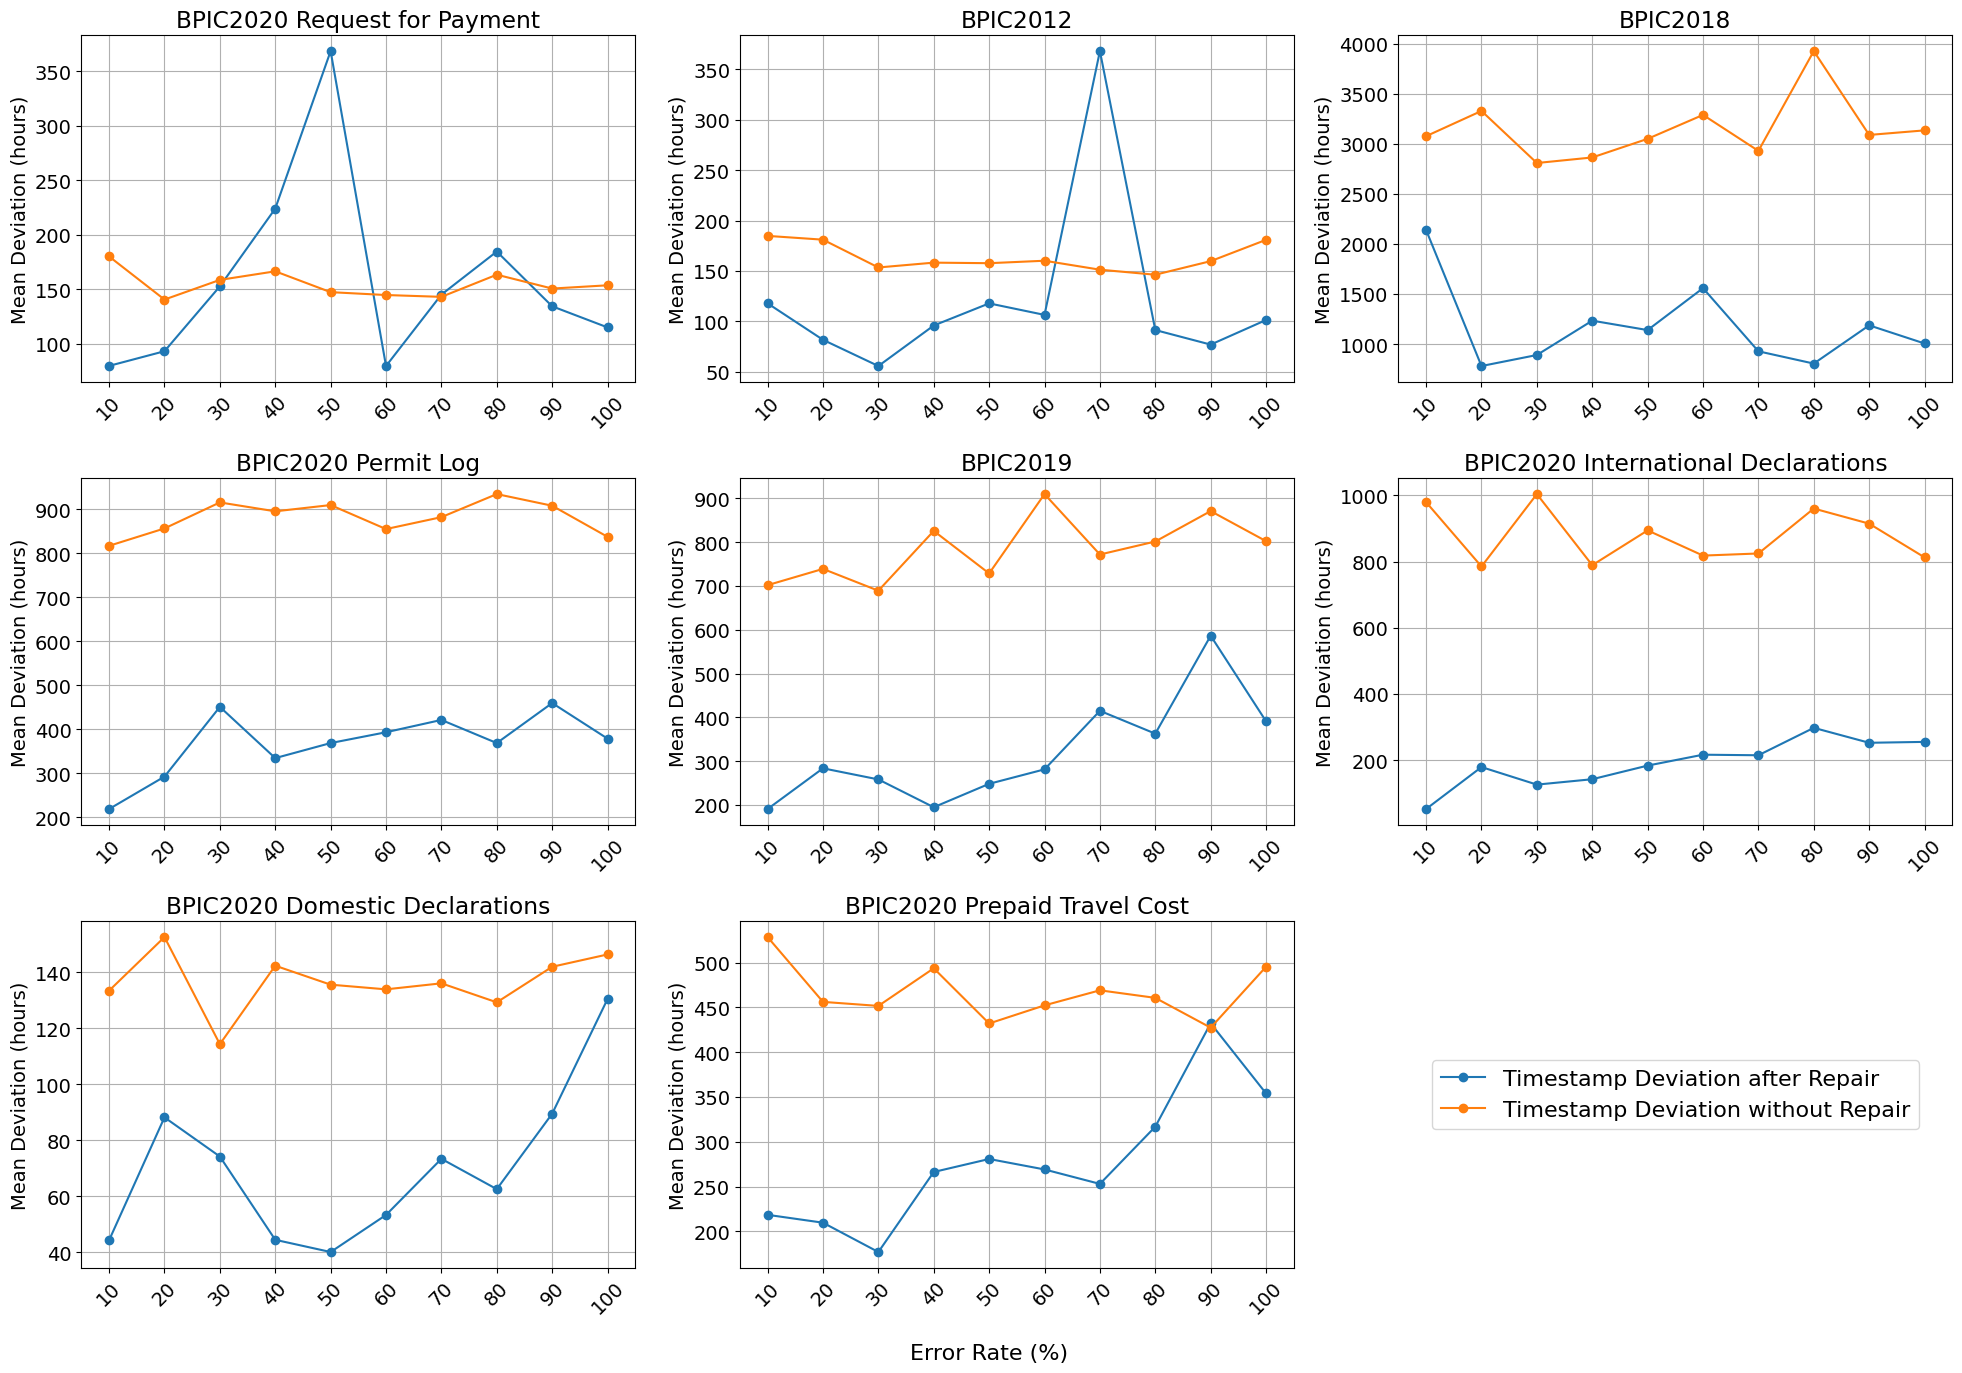

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume df_repair, df_repair_no_repair, and log_names are already available
logs = df_repair['log'].unique()
num_logs = len(logs)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axs = axs.flatten()

handles, labels = [], []
collected = set()

for ax, log in zip(axs, logs):
    df_log = df_repair[df_repair['log'] == log]
    df_baseline = df_repair_no_repair[df_repair_no_repair['log'] == log]
    
    # Convert deviation from seconds to hours
    line1, = ax.plot(df_log['error_rate'], df_log['timestamp_deviation'] / 3600, marker='o', label='Timestamp Deviation after Repair')
    line2, = ax.plot(df_baseline['error_rate'], df_baseline['timestamp_deviation'] / 3600, marker='o', label='Timestamp Deviation No Repair')
    
    if 'Timestamp Deviation after Repair' not in collected:
        handles.append(line1)
        labels.append('Timestamp Deviation after Repair')
        collected.add('Timestamp Deviation after Repair')
    if 'Timestamp Deviation without Repair' not in collected:
        handles.append(line2)
        labels.append('Timestamp Deviation without Repair')
        collected.add('Timestamp Deviation without Repair')
    
    title = log_names.get(log, log)
    ax.set_title(title)
    ax.set_ylabel('Mean Deviation (hours)')
    ax.set_xticks(df_log['error_rate'].unique())
    ax.tick_params(axis='x', labelrotation=45, labelbottom=True)
    ax.set_xlim(5, 105)
    ax.grid(True)

# Remove content from the last unused subplot and place legend there
empty_ax = axs[-1]
empty_ax.axis('off')
empty_ax.legend(handles, labels, loc='center', fontsize=16)

#fig.suptitle('Timestamp Deviation Comparison (in Hours) Across Test Logs', fontsize=16)
fig.text(0.5, 0.04, 'Error Rate (%)', ha='center', va='center', fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('../models/OTRTA_v7_instruct_base_new_system/non_accuracy_metrics.png', bbox_inches='tight')
plt.show()